In [1]:
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
from mpl_toolkits.mplot3d import Axes3D  # noqa: F401 (needed for 3D plots)
import gymnasium as gym

In [2]:
# -----------------------------
# Utility: epsilon-greedy policy
# -----------------------------

def epsilon_greedy_action(state, Q, n_actions, epsilon):
    """
    Choose an action using an ε-greedy policy w.r.t. action-value function Q.
    """
    if np.random.random() < epsilon:
        # Explore
        return np.random.randint(n_actions)
    else:
        # Exploit
        return np.argmax(Q[state])



In [3]:
# -----------------------------
# Generate one episode
# -----------------------------

def generate_episode(env, Q, n_actions, epsilon, gamma=1.0):
    """
    Generate a single episode following the current ε-greedy policy.

    Returns:
        states:  list of states
        actions: list of actions
        rewards: list of rewards
    """
    states, actions, rewards = [], [], []

    state, _ = env.reset()
    done = False

    while not done:
        action = epsilon_greedy_action(state, Q, n_actions, epsilon)
        next_state, reward, terminated, truncated, _ = env.step(action)

        states.append(state)
        actions.append(action)
        rewards.append(reward)

        state = next_state
        done = terminated or truncated  # for blackjack usually terminated only

    return states, actions, rewards



In [4]:
# -----------------------------
# First-Visit MC Control
# -----------------------------

def mc_control_first_visit_epsilon_greedy(
    env,
    num_episodes=500000,
    gamma=1.0,
    epsilon_start=1.0,
    epsilon_min=0.05,
    epsilon_decay=0.999995,
):
    """
    First-visit Monte Carlo control with ε-greedy (on-policy).

    Args:
        env: Gymnasium Blackjack-v1 environment
        num_episodes: number of training episodes
        gamma: discount factor
        epsilon_start: initial epsilon
        epsilon_min: minimum epsilon after decay
        epsilon_decay: multiplicative decay per episode

    Returns:
        Q: learned action-value function (defaultdict)
        episode_returns: list of episode returns
        epsilon_history: list of epsilon values over episodes
    """
    n_actions = env.action_space.n  # Blackjack: 0 = stick, 1 = hit

    # Q[state][action] -> action-value
    Q = defaultdict(lambda: np.zeros(n_actions))

    # For incremental averaging
    returns_count = defaultdict(lambda: np.zeros(n_actions))

    episode_returns = []
    epsilon_history = []

    epsilon = epsilon_start

    for episode_idx in range(1, num_episodes + 1):
        # Generate an episode under current ε-greedy policy
        states, actions, rewards = generate_episode(env, Q, n_actions, epsilon, gamma)

        # Compute returns backward
        G = 0.0
        visited = set()  # track (state, action) first visits

        for t in reversed(range(len(states))):
            s = states[t]
            a = actions[t]
            r = rewards[t]

            G = r + gamma * G

            # First-visit MC: only update once per (s,a) in this episode
            if (s, a) not in visited:
                visited.add((s, a))
                returns_count[s][a] += 1.0
                alpha = 1.0 / returns_count[s][a]  # sample-average step-size
                Q[s][a] += alpha * (G - Q[s][a])

        episode_return = sum(rewards)
        episode_returns.append(episode_return)
        epsilon_history.append(epsilon)

        # Decay epsilon (on-policy ε-soft control)
        epsilon = max(epsilon_min, epsilon * epsilon_decay)

        # Optional: print progress occasionally
        if episode_idx % 100000 == 0:
            avg_last = np.mean(episode_returns[-10000:])
            print(
                f"Episode {episode_idx}/{num_episodes} "
                f"| Avg return (last 10k): {avg_last:.3f} "
                f"| ε: {epsilon:.3f}"
            )

    return Q, episode_returns, epsilon_history



In [5]:
# -----------------------------
# Value Function & Policy Helpers
# -----------------------------

def get_state_value_from_Q(Q, usable_ace=True):
    """
    Build 2D arrays for value function:
    - player sum: 12 to 21
    - dealer showing: 1 to 10

    Returns:
        X, Y: meshgrid for plotting
        Z: 2D array of state values (max_a Q(s,a))
    """
    player_sums = np.arange(12, 22)      # 12-21
    dealer_cards = np.arange(1, 11)      # 1-10

    Z = np.zeros((len(player_sums), len(dealer_cards)))

    for i, player in enumerate(player_sums):
        for j, dealer in enumerate(dealer_cards):
            state = (player, dealer, usable_ace)
            if state in Q:
                Z[i, j] = np.max(Q[state])
            else:
                Z[i, j] = 0.0  # unvisited states default

    X, Y = np.meshgrid(dealer_cards, player_sums)
    return X, Y, Z


def get_policy_from_Q(Q, usable_ace=True):
    """
    Build 2D array for greedy policy:
    - 0 = stick, 1 = hit

    Returns:
        player_sums, dealer_cards, policy_grid
    """
    player_sums = np.arange(12, 22)      # 12-21
    dealer_cards = np.arange(1, 11)      # 1-10

    policy_grid = np.zeros((len(player_sums), len(dealer_cards)), dtype=int)

    for i, player in enumerate(player_sums):
        for j, dealer in enumerate(dealer_cards):
            state = (player, dealer, usable_ace)
            if state in Q:
                policy_grid[i, j] = np.argmax(Q[state])
            else:
                # default: hit (1) if we have no info
                policy_grid[i, j] = 1

    return player_sums, dealer_cards, policy_grid


In [6]:
# -----------------------------
# Plotting Functions
# -----------------------------

def plot_learning_curve(episode_returns, window=5000):
    """
    Plot smoothed average return over episodes.
    """
    episode_returns = np.array(episode_returns)
    if len(episode_returns) >= window:
        kernel = np.ones(window) / window
        smoothed = np.convolve(episode_returns, kernel, mode="valid")
        x = np.arange(len(smoothed))
        plt.figure()
        plt.plot(x, smoothed)
        plt.xlabel(f"Episode (smoothed over window={window})")
        plt.ylabel("Average Return")
        plt.title("Learning Curve: Average Return vs Episodes")
        plt.grid(True)
        plt.tight_layout()
        plt.show()
    else:
        plt.figure()
        plt.plot(episode_returns)
        plt.xlabel("Episode")
        plt.ylabel("Return")
        plt.title("Learning Curve: Average Return vs Episodes")
        plt.grid(True)
        plt.tight_layout()
        plt.show()


def plot_value_surface(Q, usable_ace=True):
    """
    3D surface plot of state value function.
    """
    X, Y, Z = get_state_value_from_Q(Q, usable_ace=usable_ace)

    fig = plt.figure()
    ax = fig.add_subplot(111, projection="3d")
    surf = ax.plot_surface(X, Y, Z, rstride=1, cstride=1, linewidth=0, antialiased=False)

    ax.set_xlabel("Dealer Showing")
    ax.set_ylabel("Player Sum")
    ax.set_zlabel("Value")
    title_suffix = "Usable Ace" if usable_ace else "No Usable Ace"
    ax.set_title(f"MC Estimated Value Function ({title_suffix})")

    fig.colorbar(surf, shrink=0.5, aspect=5)
    plt.tight_layout()
    plt.show()


def plot_policy_heatmap(Q, usable_ace=True):
    """
    Heatmap of greedy policy: 0 = stick, 1 = hit.
    """
    player_sums, dealer_cards, policy_grid = get_policy_from_Q(Q, usable_ace=usable_ace)

    plt.figure()
    im = plt.imshow(
        policy_grid,
        origin="lower",
        aspect="auto",
        extent=[
            dealer_cards[0] - 0.5,
            dealer_cards[-1] + 0.5,
            player_sums[0] - 0.5,
            player_sums[-1] + 0.5,
        ],
    )

    plt.colorbar(im, ticks=[0, 1], label="Action")
    plt.clim(-0.5, 1.5)
    plt.xlabel("Dealer Showing")
    plt.ylabel("Player Sum")
    title_suffix = "Usable Ace" if usable_ace else "No Usable Ace"
    plt.title(f"Greedy Policy Heatmap (0=Stick, 1=Hit) - {title_suffix}")
    plt.tight_layout()
    plt.show()



Starting First-Visit MC Control training...
Episode 100000/500000 | Avg return (last 10k): -0.258 | ε: 0.607
Episode 200000/500000 | Avg return (last 10k): -0.178 | ε: 0.368
Episode 300000/500000 | Avg return (last 10k): -0.134 | ε: 0.223
Episode 400000/500000 | Avg return (last 10k): -0.100 | ε: 0.135
Episode 500000/500000 | Avg return (last 10k): -0.072 | ε: 0.082
Training finished.


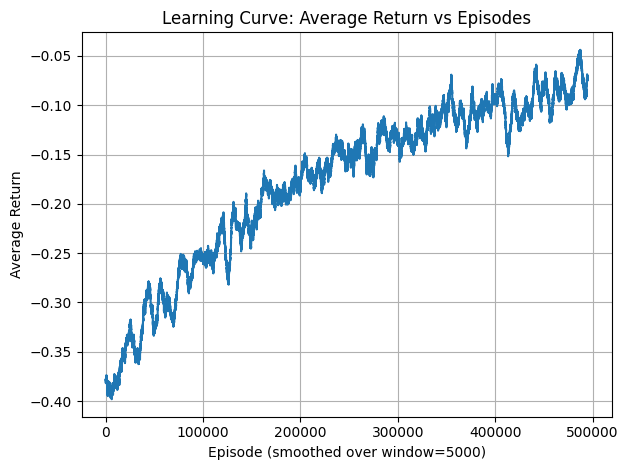

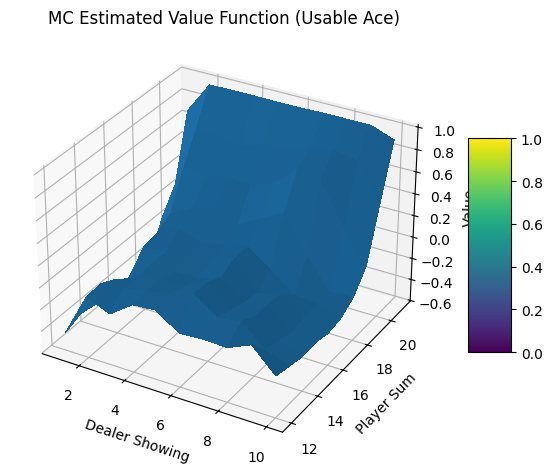

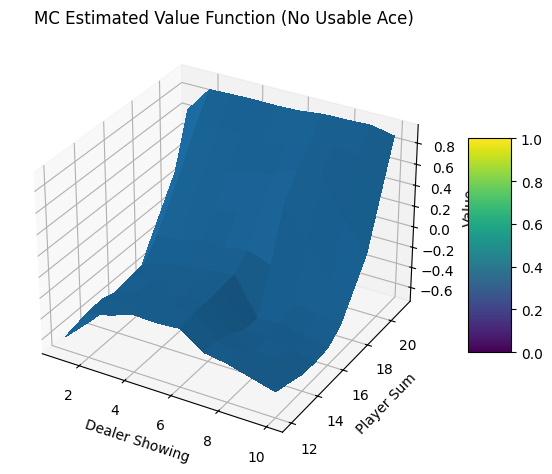

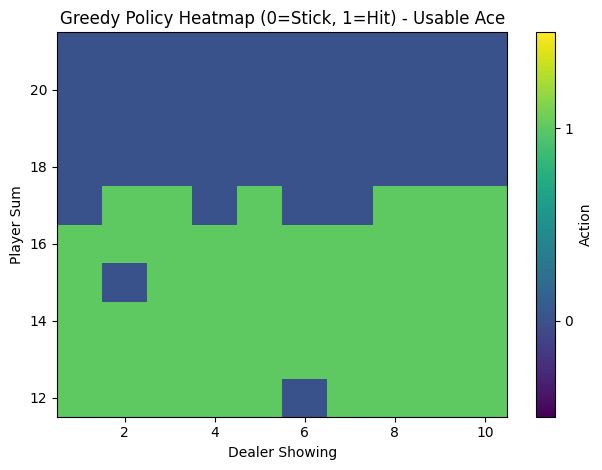

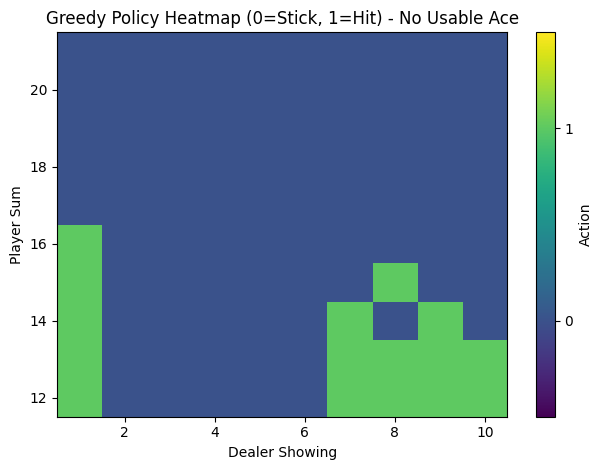

In [7]:
# -----------------------------
# Main
# -----------------------------

def main():
    # Use sab=True to match Sutton & Barto version of Blackjack
    env = gym.make("Blackjack-v1", sab=True)

    # Training settings (you can adjust num_episodes for quicker tests)
    num_episodes = 500000
    gamma = 1.0
    epsilon_start = 1.0
    epsilon_min = 0.05
    epsilon_decay = 0.999995  # decays epsilon roughly over training

    print("Starting First-Visit MC Control training...")
    Q, episode_returns, epsilon_history = mc_control_first_visit_epsilon_greedy(
        env,
        num_episodes=num_episodes,
        gamma=gamma,
        epsilon_start=epsilon_start,
        epsilon_min=epsilon_min,
        epsilon_decay=epsilon_decay,
    )
    print("Training finished.")

    # Plot learning curve
    plot_learning_curve(episode_returns, window=5000)

    # Plot value function surfaces
    plot_value_surface(Q, usable_ace=True)
    plot_value_surface(Q, usable_ace=False)

    # Plot greedy policy heatmaps
    plot_policy_heatmap(Q, usable_ace=True)
    plot_policy_heatmap(Q, usable_ace=False)


if __name__ == "__main__":
    main()